In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
import time
import copy
from torchvision import datasets, transforms
from torch import nn, optim
import warnings
warnings.filterwarnings("ignore")
import torchvision.models as models
import torch, torch.nn as nn
import math
import torch.nn.functional as F
from torch.autograd import Variable
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

def transform(my_x, my_y):
    tensor_x = torch.Tensor(my_x) # transform to torch tensor
    tensor_y = torch.LongTensor(my_y)

    my_dataset = data.TensorDataset(tensor_x,tensor_y) # create your datset
    my_dataloader = data.DataLoader(my_dataset) # create your dataloader
    return my_dataloader
    
def T_scaling(logits, temperature):
  return torch.div(logits, temperature)

def compute_loss(X_batch, y_batch):
    X_batch = Variable(torch.FloatTensor(X_batch))
    y_batch = Variable(torch.LongTensor(y_batch))
    X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
    logits = resnet18(X_batch)
    #temperature = nn.Parameter(torch.ones(1) * temp_constant)
    #temperature = temperature.unsqueeze(1).expand(logits.size(0), logits.size(1)).cuda()
    #return F.cross_entropy(T_scaling(logits, temperature), y_batch).mean()
    return F.cross_entropy(logits, y_batch).mean()

In [2]:
transform = transforms.ToTensor()
batch_size=100

transform_train = transforms.Compose([
    transforms.RandomCrop(28, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

trainset = datasets.FashionMNIST('fashion-10', download=True, train=True, transform=transform)
testset = datasets.FashionMNIST('fashion-10', download=True, train=False, transform=transform)
print(trainset[0][0].shape)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=True)

Extracting fashion-10/FashionMNIST/raw/train-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/train-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to fashion-10/FashionMNIST/raw


Extracting fashion-10/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to fashion-10/FashionMNIST/raw
Processing...
Done!
torch.Size([1, 28, 28])


In [3]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class Bottleneck(nn.Module):
    expansion = 4

    def __init__(self, in_planes, planes, stride=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, self.expansion*planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(self.expansion*planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def ResNet18():
    return ResNet(BasicBlock, [2,2,2,2])

In [4]:
def cyclical_lr(stepsize, min_lr=3e-4, max_lr=3e-3):

    # Scaler: we can adapt this if we do not want the triangular CLR
    scaler = lambda x: 1. #* math.exp(-x * 0.1)

    # Lambda function to calculate the LR
    lr_lambda = lambda it: min_lr + (max_lr - min_lr) * relative(it, stepsize)

    # Additional function to see where on the cycle we are
    def relative(it, stepsize):
        cycle = math.floor(1 + it / (2 * stepsize))
        x = abs(it / stepsize - 2 * cycle + 1)
        return max(0, (1 - x)) * scaler(cycle)
    return lr_lambda

In [5]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=480, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        return logits#, probs

In [6]:
import time
import copy

temps = [0.1, 2., 3.]
torch.cuda.empty_cache()
#resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
resnet18 = LeNet5(10)
cnt = 0
for el in resnet18.parameters():
  cnt += 1
print(cnt)
resnet18 = resnet18.cuda()

num_epochs = 21
start_lr = 0.01
end_lr = 0.1
factor = 10
#temperature = nn.Parameter(torch.ones(1).cuda())
#opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


step_size = 1*len(trainset) / batch_size
print(step_size)
clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

models_list = []
weight_list = []
loss_list = []

train_loss = []
val_accuracy = []
losses = []
accs = []

lr_find_loss = []
learning_rates = []

it = 0

smoothing = 0.5
small_flag = False
lrs = []

for epoch in range(num_epochs):
    start_time = time.time()
    resnet18.train(True)
    for (X_batch, y_batch) in trainloader:
        loss = compute_loss(X_batch, y_batch)
        loss.backward()
        opt.step()
        num_loss = loss.data.cpu().numpy()
        train_loss.append(num_loss)
        
        scheduler.step()
        opt.zero_grad()

        lr_step = opt.state_dict()["param_groups"][0]["lr"]
        learning_rates.append(lr_step)
        #print(lr_step)
        if lr_step <= 0.00103:
            #print('add minimun')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(10.)
            #val_loss = 0.
            #for (X_batch, y_batch) in testloader:
            #    val_loss += compute_loss(X_batch, y_batch)
            #val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            #print('min', val_loss)
            #loss_list.append(val_loss)
            loss_list.append(num_loss)
        elif lr_step <= 0.00502 and lr_step > 0.00499:
            #print('add not minimum')
            models_list.append(copy.deepcopy(resnet18))
            weight_list.append(1.)
            #val_loss = 0.
            #for (X_batch, y_batch) in testloader:
            #    val_loss += compute_loss(X_batch, y_batch)
            #val_loss = val_loss.detach().cpu().numpy() * batch_size/ len(testloader.dataset)
            #print('not', val_loss)
            #loss_list.append(val_loss)
            loss_list.append(num_loss)
        if len(models_list) > 25:
          models_list = models_list[-25:]
        it += 1
              

        resnet18.train(False)
        for (X_batch, y_batch) in testloader:
            y_batch = y_batch.cuda()
            logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
        cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
    if epoch % 5 == 0:
        print("Epoch {} of {} took {:.3f}s".format(
            epoch + 1, num_epochs, time.time() - start_time))
        print("  training loss (in-iteration): \t{:.6f}".format(
            np.mean(train_loss[-len(trainset) // batch_size :])))
        print("  validation accuracy: \t\t\t{:.2f} %".format(
            np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
    losses.append(np.array(train_loss).mean())

10
600.0
Epoch 1 of 21 took 438.777s
  training loss (in-iteration): 	0.668104
  validation accuracy: 			77.99 %
Epoch 6 of 21 took 433.422s
  training loss (in-iteration): 	0.437851
  validation accuracy: 			85.11 %
Epoch 11 of 21 took 456.744s
  training loss (in-iteration): 	0.395283
  validation accuracy: 			82.46 %
Epoch 16 of 21 took 441.462s
  training loss (in-iteration): 	0.409794
  validation accuracy: 			85.24 %
Epoch 21 of 21 took 436.912s
  training loss (in-iteration): 	0.386784
  validation accuracy: 			81.61 %


In [7]:
torch.save(resnet18.state_dict(), 'lenet_big_lr.pt')
from google.colab import files
files.download('lenet_big_lr.pt') 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [8]:
original_loss_list = loss_list
original_loss_list

[array(2.3120134, dtype=float32),
 array(0.51430273, dtype=float32),
 array(0.42425945, dtype=float32),
 array(0.43325338, dtype=float32),
 array(0.42850947, dtype=float32),
 array(0.39117768, dtype=float32),
 array(0.3618521, dtype=float32),
 array(0.4577246, dtype=float32),
 array(0.43423927, dtype=float32),
 array(0.73467636, dtype=float32),
 array(0.23085862, dtype=float32),
 array(0.41291267, dtype=float32),
 array(0.48915988, dtype=float32),
 array(0.3649412, dtype=float32),
 array(0.39491677, dtype=float32),
 array(0.5571935, dtype=float32),
 array(0.38089612, dtype=float32),
 array(0.33748025, dtype=float32),
 array(0.34904918, dtype=float32),
 array(0.3902484, dtype=float32),
 array(0.4294573, dtype=float32),
 array(0.35914227, dtype=float32),
 array(0.5199879, dtype=float32),
 array(0.47909874, dtype=float32),
 array(0.38603854, dtype=float32),
 array(0.36644632, dtype=float32),
 array(0.42099574, dtype=float32),
 array(0.67682844, dtype=float32),
 array(0.42453864, dtype=flo

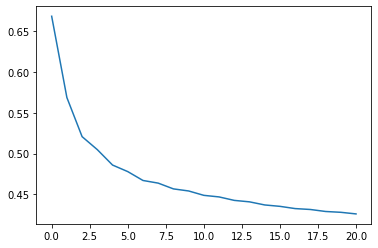

In [9]:
plt.plot(np.array(list(range(len(losses)))), losses)
#plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 10))
plt.show()

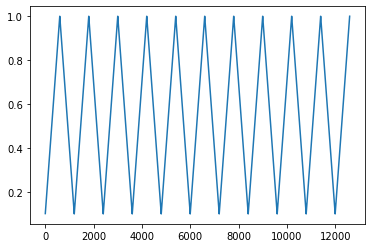

In [10]:
plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 100))
plt.show()

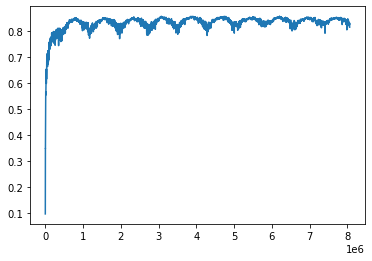

In [11]:
plt.plot(np.array(list(range(len(accs)))) * 640, accs)
#plt.plot(list(range(len(learning_rates))), (np.array(learning_rates) * 10))
plt.show()

In [12]:
def weigheted_most_common(predictions, weights):
    new_predictions = {}
    for i in range(len(predictions)):
        if predictions[i] in new_predictions:
            new_predictions[predictions[i]] = new_predictions[predictions[i]] + weights[i]
        else:
            new_predictions[predictions[i]] = weights[i]
    top = list(sorted(new_predictions.items(), key=lambda item: item[1], reverse=True))
    return top[0][0]
from collections import Counter
import numpy as np
def ensemble_predictions(members, loader, weights):
    accs = []
    for (X_batch, y_batch) in loader:
        yhats = []
        for model in members:
            y_batch = y_batch.cuda()
            logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            #print(y_pred.cpu().numpy())
            yhats.append(y_pred.cpu().numpy())
        yhats = np.array(yhats)
        maxs = []
        for i in range(yhats.shape[1]):
            cur_max = weigheted_most_common(yhats[:, i], weights)
            maxs.append(cur_max)
            #weighted_yhats = np.bincount(yhats[:, i], weights)
            #most_freq = np.argmax(weighted_yhats)
            #maxs.append(yhats[:, i][most_freq])
            #amounts = Counter(yhats[:, i])
            #most_freq = amounts.most_common(1)
            #maxs.append(most_freq[0][0])
        # sum across ensemble members
        maxs = np.array(maxs)
        # argmax across classes
        accs.append(np.mean((y_batch.cpu().numpy() == maxs)))
    accs = np.array(accs)
    return accs, np.mean(accs)

In [13]:
temps = [0.1, 0.3, 0.5, 0.8, 1.1, 1.5,]
#original_loss_list = loss_list
ens_accs = []
print(len(models_list))
for t in temps:
    temp_constant = t
    loss_list = np.array(original_loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    #print(loss_list)
    for i in range(loss_list.shape[0]):
        loss_list[i] = np.exp(loss_list[i] / temp_constant)

    weights = loss_list#np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    print(weights)
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print(t, 'Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

25
[ 96.959625  21.082836 112.496635  33.314873  32.672443  37.66122
 154.86368   47.574684  33.57357   61.9642    18.332357  52.855515
 151.03873   39.65247   47.72328   28.714666  45.316013  37.534492
  19.857084 256.7578    37.059902  38.27972   42.977974  54.85467
  19.705933]
0.1 Ensemble accuracy =  86.3 %
[4.5940633 2.762547  4.827399  3.2177038 3.1968863 3.3519547 5.37011
 3.6234753 3.226011  3.9571297 2.636773  3.7528691 5.325529  3.4100184
 3.627244  3.0622075 3.5652    3.3481905 2.7079365 6.3558636 3.3340192
 3.3702044 3.5027997 3.7996    2.7010481]
0.3 Ensemble accuracy =  86.4 %
[2.496423  1.8398644 2.571745  2.0161722 2.0083358 2.066231  2.7415104
 2.1650863 2.0192938 2.2825913 1.7891372 2.2111492 2.7278323 2.0876324
 2.166437  1.9571348 2.1441262 2.0648386 1.8179549 3.0332258 2.0595903
 2.0729735 2.12153   2.2276282 1.8151788]
0.5 Ensemble accuracy =  86.3 %
[1.7714294 1.4638317 1.8046478 1.5499932 1.5462251 1.573935  1.878208
 1.6205857 1.5514926 1.6750108 1.4384749 1.6

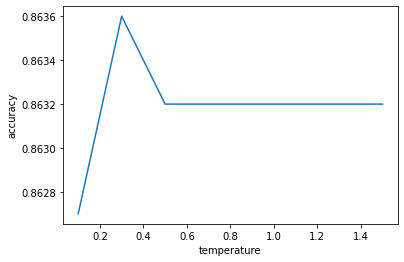

In [14]:
plt.plot(temps, ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [15]:
for model in models_list:
  accuracy = []
  for (X_batch, y_batch) in testloader:
          y_batch = y_batch.cuda()
          logits = model(Variable(torch.FloatTensor(X_batch)).cuda())
          y_pred = logits.max(1)[1].data
          accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
  print(np.array(accuracy).mean() * 100, '%')

84.78999999999999 %
84.75999999999998 %
84.77999999999999 %
84.88999999999999 %
83.94999999999997 %
83.96 %
85.30999999999999 %
85.24 %
85.21999999999998 %
84.89999999999998 %
84.67999999999999 %
83.46 %
83.52000000000001 %
85.05999999999997 %
85.14 %
85.09 %
84.27000000000001 %
84.48 %
83.29 %
83.59999999999998 %
85.16000000000003 %
85.16 %
85.10000000000001 %
84.83 %
84.89999999999999 %


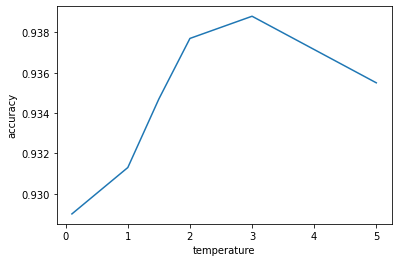

In [ ]:
small_ens_accs = ens_accs
plt.plot(temps, small_ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()

In [ ]:
weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
print(round(mean_accs, 3) * 100, '%')

93.8 %


In [ ]:
import time
import copy

temps = [6., 10.]
#ens_accs = []

for t in temps:
    torch.cuda.empty_cache()
    print('Experiment for t = {}'.format(t))
    temp_constant = t
    resnet18 = ResNet(BasicBlock, [2,2,2,2]) #models.resnet18(num_classes=10, pretrained=False)
    resnet18 = resnet18.cuda()

    num_epochs = 21
    start_lr = 0.01
    end_lr = 0.1
    factor = 10
    temperature = nn.Parameter(torch.ones(1).cuda())
    #opt = torch.optim.LBFGS(list(resnet18.parameters()) + [temperature], lr=end_lr, max_iter=10000, line_search_fn='strong_wolfe')
    opt = torch.optim.Adam(resnet18.parameters(), lr=end_lr)


    step_size = 1*len(trainset) / batch_size
    print(step_size)
    clr = cyclical_lr(step_size, min_lr=start_lr, max_lr=end_lr)
    scheduler = torch.optim.lr_scheduler.LambdaLR(opt, [clr])

    models_list = []
    weight_list = []
    loss_list = []

    train_loss = []
    val_accuracy = []
    losses = []
    accs = []

    lr_find_loss = []
    learning_rates = []

    it = 0

    smoothing = 0.5
    small_flag = False
    lrs = []

    for epoch in range(num_epochs):
        start_time = time.time()
        resnet18.train(True)
        for (X_batch, y_batch) in trainloader:
            loss = compute_loss(X_batch, y_batch)
            loss.backward()
            opt.step()
            #print(loss.data.cpu().numpy())
            train_loss.append(loss.data.cpu().numpy())
            
            scheduler.step()
            opt.zero_grad()

            lr_step = opt.state_dict()["param_groups"][0]["lr"]
            learning_rates.append(lr_step)
            #lr_find_loss.append(loss)
            if lr_step <= 0.00103:
                #print('add minimun')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(10.)
                loss_list.append(loss)
            elif lr_step <= 0.00502 and lr_step > 0.00499:
                #print('add not minimum')
                models_list.append(copy.deepcopy(resnet18))
                weight_list.append(1.)
                loss_list.append(loss)
            if len(models_list) > 25:
              models_list = models_list[-25:]
            it += 1
            

        resnet18.train(False)
        for (X_batch, y_batch) in testloader:
            y_batch = y_batch.cuda()
            logits = resnet18(Variable(torch.FloatTensor(X_batch)).cuda())
            y_pred = logits.max(1)[1].data
            val_accuracy.append(np.mean((y_batch.cpu() == y_pred.cpu()).numpy() ))
        
        accs.append(np.mean(val_accuracy[-len(testset) // batch_size :]))
        cur_loss = np.mean(train_loss[-len(trainset) // batch_size :])


        
        if epoch % 10 == 0:
            print("Epoch {} of {} took {:.3f}s".format(
                epoch + 1, num_epochs, time.time() - start_time))
            print("  training loss (in-iteration): \t{:.6f}".format(
                np.mean(train_loss[-len(trainset) // batch_size :])))
            print("  validation accuracy: \t\t\t{:.2f} %".format(
                np.mean(val_accuracy[-len(testset) // batch_size :]) * 100))
        losses.append(np.array(train_loss).mean())
    loss_list = np.array(loss_list[-len(models_list):])
    #weight_list = weight_list[-len(models_list):]
    for i in range(loss_list.shape[0]):
        loss_list[i] = loss_list[i].detach().cpu().numpy()
    weights = np.array(1. / loss_list, dtype=np.float64) #weight according likelyhood 
    accs, mean_accs = ensemble_predictions(models_list, testloader, weights)
    ens_accs.append(mean_accs)
    print('Ensemble accuracy = ', round(mean_accs, 3) * 100, '%')

Experiment for t = 6.0


RuntimeError: ignored

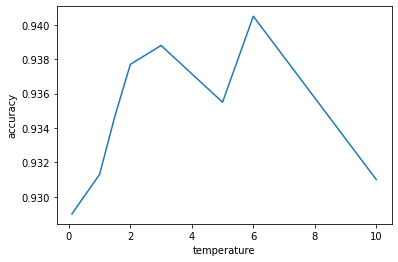

In [ ]:
plt.plot([0.1, 1., 1.5, 2., 3., 5., 6., 10.], ens_accs)
plt.xlabel('temperature')
plt.ylabel('accuracy')
plt.show()